In [ ]:
!pip install --upgrade scikit-surprise
!pip install --upgrade recmetrics

In [29]:
from pathlib import Path

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import surprise
from surprise import accuracy, SVD, BaselineOnly, KNNWithMeans
from surprise.model_selection import train_test_split
import recmetrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = Path("/content/drive/MyDrive/merged_data.csv")

In [30]:
main_df = pd.read_csv(data_path)
main_df = main_df[main_df.state.isin(['PA'])] # Top three states: PA, FL, LA

In [31]:
# create a label encoder for user_id and business_id
(user_encoder, business_encoder) = (LabelEncoder(), LabelEncoder())

# fit the encoders to the data
user_encoder.fit(main_df['user_id'])
business_encoder.fit(main_df['business_id'])

# encode the user_id and business_id columns
main_df['user_id_encoded'] = user_encoder.transform(main_df['user_id'])
main_df['business_id_encoded'] = business_encoder.transform(main_df['business_id'])

main_df.head()

,user_id,business_id,name,state,stars,text,user_id_encoded,business_id_encoded
4,s_9uD6zqVU-9cnKO9pDKtg,jMi5SL9vb6nLJGRjw0HK3Q,Civera's Deli,PA,5,Civera's Deli is the cleanest deli in Delco. E...,35748,16884
6,JOrDiXIgpb0sjtd7Cr3CdA,RUfWgnSSQKjRNBpK0wSxfg,Isabella Pizza,PA,1,Yuck. I ordered here this morning for breakfas...,13018,10173
7,PXywFGVuClrMdFcq5RjsEg,7WWLPXpOjrh_1EvjFuw3hQ,The Drake Tavern,PA,5,Probably the best place to eat in Jenkintown. ...,16808,3076
17,FyIoTnxVTbNar4KdG6cC1w,N1a7z4ID9K0Hqz-Zf3V3yw,US Inspect,PA,5,I recently had a home inspection with Nate Fel...,10781,8582
19,Nro6ABevZFu-8TFDKS-5bw,ctHjyadbDQAtUFfkcAFEHw,Zahav,PA,5,I had the amazing opportunity to eat at Zahab ...,15760,14510


In [32]:
# Load the DataFrame into a Surprise Dataset object
reader = surprise.Reader(rating_scale=(1, 5))
data = surprise.Dataset.load_from_df(main_df[['user_id_encoded', 'business_id_encoded', 'stars']], reader)

data.df.head()

,user_id_encoded,business_id_encoded,stars
4,35748,16884,5
6,13018,10173,1
7,16808,3076,5
17,10781,8582,5
19,15760,14510,5


In [33]:
(len(data.df["user_id_encoded"].unique()), len(data.df["business_id_encoded"].unique()))

(40502, 22984)

In [34]:
# Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.25)

In [35]:
(train.n_items, train.n_users)

(22835, 39601)

In [36]:
df_test = pd.DataFrame(test, columns=["user_id", "business_id", "actual"]).copy().groupby('user_id', as_index=False)['business_id'].agg({'actual': (lambda x: list(set(x)))})
df_test = df_test.set_index("user_id")
df_test

,actual
user_id,
0,"[17445, 12678, 21233, 7506, 16691, 6867, 24]"
1,[20129]
3,"[10183, 17256, 8167, 6024, 16715, 21512, 1553,..."
4,"[1876, 3822]"
5,"[7041, 2476, 8338, 12508, 7380, 5242, 19899, 2..."
...,...
40497,"[4153, 16551, 13151]"
40498,[16558]
40499,"[17915, 16006]"


## Generating Random and Popularity based Predictions

In [37]:
#make recommendations for all members in the test data
popularity_recs = main_df.business_id.value_counts().head(10).index.tolist()

pop_recs = []
for user in df_test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
df_test['pop_preds'] = pop_recs

In [38]:
#make recommendations for all members in the test data
ran_recs = []
for user in df_test.index:
    random_predictions = main_df.business_id.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
df_test['random_preds'] = ran_recs

## Training all the models and getting user recommendations

In [39]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [40]:
def get_models_preds(algos: list, names: list, n: int) -> pd.DataFrame:
  for i, algo in enumerate(algos):
    preds = algo.test(test)
    df_preds = pd.DataFrame(preds)

    model = df_preds.pivot_table(index='uid', columns='iid', values='est').fillna(0)

    model_recs = []
    for user in df_test.index:
        predictions = get_users_predictions(user, n, model)
        model_recs.append(predictions)
            
    df_test[names[i]] = model_recs
    del model
  
  return df_test

In [41]:
models = [
    BaselineOnly(bsl_options={"method": "sgd"}).fit(train),
    # SVD().fit(train),
    # BaselineOnly(bsl_options={"method": "als"}).fit(train),
    # KNNWithMeans(k=40, sim_options={'name': 'cosine', 'user_based': False}).fit(train)
]

Estimating biases using sgd...


In [42]:
all_preds = get_models_preds(models, [
      "sgd_preds",
      # "svd_preds",
      # "als_preds",
      # "knn_mean_item_preds"
    ], 10)

In [43]:
actual = all_preds.actual.values.tolist()
sgd_preds = all_preds.sgd_preds.values.tolist()
pop_preds = all_preds.pop_preds.values.tolist()
rand_preds = all_preds.random_preds.values.tolist()

In [44]:
def get_mark_scores(actual, model_preds: list):
  all_marks = []
  for pred in model_preds:
    model_mark = []
    for K in np.arange(1, 11):
        model_mark.extend([recmetrics.mark(actual, pred, k=K)])
    all_marks.append(model_mark)

  return all_marks

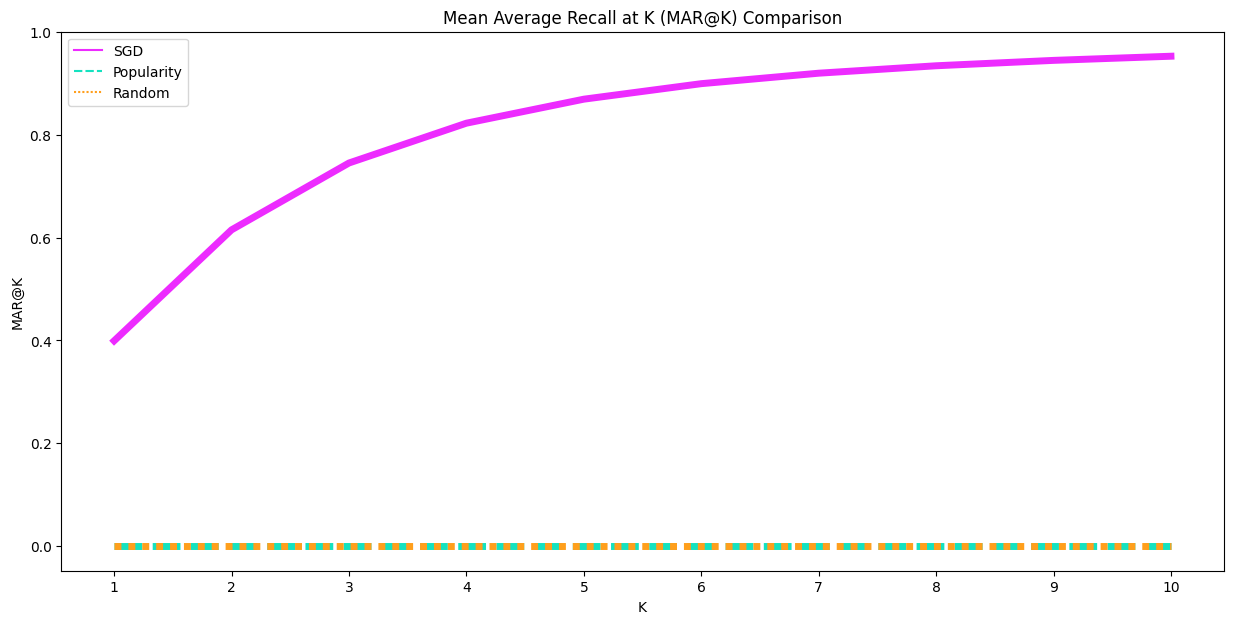

In [46]:
mark_scores = get_mark_scores(actual, [sgd_preds, pop_preds, rand_preds])
index = range(1,10+1)
names = ['SGD', 'Popularity', 'Random']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [47]:
catalog = main_df.business_id.unique().tolist()
random_coverage = recmetrics.prediction_coverage(ran_recs, catalog)
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
sgd_coverage = recmetrics.prediction_coverage(sgd_preds, catalog)

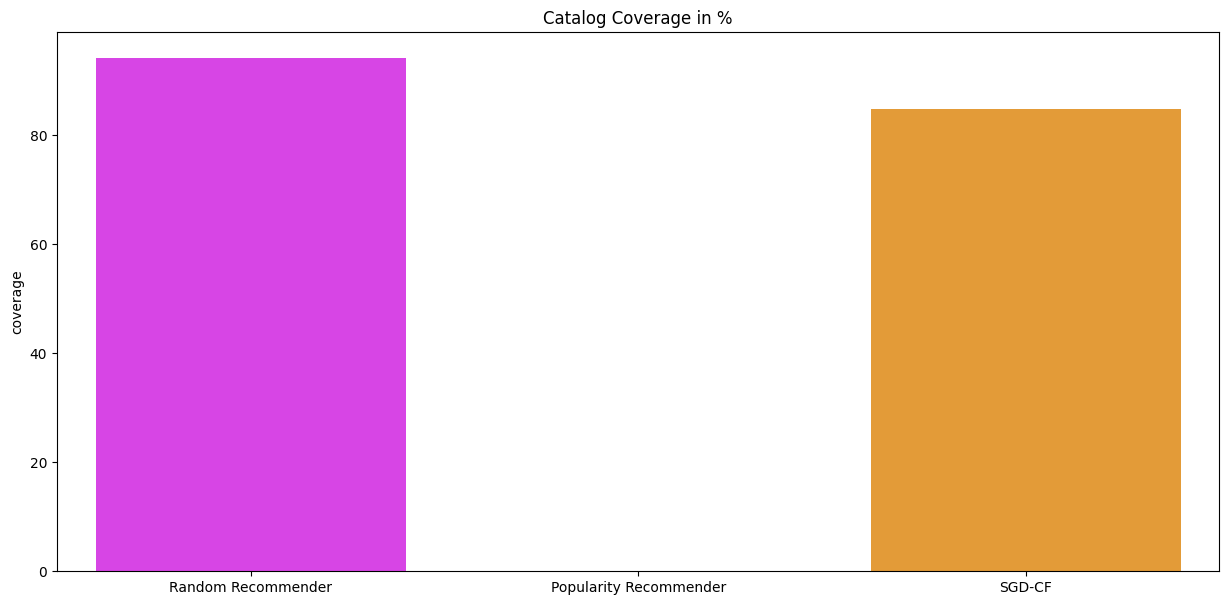

In [49]:
# plot of prediction coverage
coverage_scores = [random_coverage, pop_coverage, sgd_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'SGD-CF']

fig = plt.figure(figsize=(15, 7))
recmetrics.coverage_plot(coverage_scores, model_names)